In [9]:
import numpy as np
import pandas as pd

from Code.diversity import * 

import bisect
from itertools import combinations
import matplotlib.pyplot as plt

from getBenchmarkData import *

df = pd.read_pickle(f'./E1 results/E1 for analysis/E1.2 results u parameter 20250127160502.pkl')
df_config = np.load(f'./E1 results/E1 for analysis/E1.2 results u parameter 20250127160502_config.npy',allow_pickle=True)

In [10]:
df_config

array({'max_time_limit_minutes': 5, 'save_title': 'E1.2 results u parameter 20250127160502', 'z': 2, 'd': 3, 'q': 500, 'bins': 5, 'min_cov': 0.05, 'min_coverage_abs': 3, 'correct_for_size': <function no_size_corr at 0x000001A335694B80>, 'comparison_type': 'complement', 'similarity_threshold': 0.5, 'dataset_selection': 'all'},
      dtype=object)

In [2]:
df

,dataset_name,u,max_quality,avg_quality,max_coverage,avg_coverage,duration,count_quality,time_per_group,redundancy,diversity,results_descriptions,results_non_redundant
0,wisconsin,500,0.865,0.737161,0.201,0.075113,24.778427,1340,0.018,0.698000,111.232925,"[[-1.72016 <= A5 <= -0.88298, -0.822634 <= A8 ...","[[-1.72016 <= A5 <= -0.88298, -0.822634 <= A8 ..."
1,cpu,500,0.575,0.525011,0.328,0.134081,18.423056,36,0.512,0.194444,15.185971,"[[0.8352480000000001 <= A3 <= 6.23566, 0.36729...","[[0.8352480000000001 <= A3 <= 6.23566, 0.36729..."
2,voting,500,1.214,1.148105,0.103,0.059624,5692.715679,87094,0.065,0.778000,127.923454,[[0.2909699 <= Companiesbytypebusinessservices...,[[0.2909699 <= Companiesbytypebusinessservices...
3,student_math,500,0.419,0.341224,0.949,0.090061,135.857616,24804,0.005,0.682000,54.424335,"[[1.0 <= failures <= 3.0, school == 'GP', paid...","[[1.0 <= failures <= 3.0, school == 'GP', paid..."
4,student_por,500,0.317,0.262953,0.894,0.083149,119.939909,20667,0.006,0.712000,37.813038,"[[0.0 <= failures <= 3.0, famsup == 'no', nurs...","[[0.0 <= failures <= 3.0, famsup == 'no', nurs..."
5,elevators,500,0.657,0.554657,0.300,0.119752,54.495166,26,2.096,0.230769,11.122250,"[[-4.35408 <= A4 <= -0.81551, 0.24224 <= A8 <=...","[[-4.35408 <= A4 <= -0.81551, 0.24224 <= A8 <=..."
6,ecoli,500,0.768,0.491003,0.997,0.127946,0.882288,196,0.005,0.744898,24.539736,"[[A4 == '0'], [A3 == '0'], [A4 == '0', A3 == '...","[[A4 == '0'], [-0.97795 <= A1 <= -0.36049, -0...."
7,wine,500,0.804,0.562626,0.247,0.080783,4.533447,319,0.014,0.351097,110.311760,"[[0.09842799999999996 <= A13 <= 1.0], [0.09842...","[[0.09842799999999996 <= A13 <= 1.0], [0.43473..."
8,sushi,500,0.967,0.926067,0.690,0.114468,36.268898,657,0.055,0.798000,93.800652,"[[sex == '0', 1.0 <= age <= 2.0, changed_city ...","[[sex == '0', 1.0 <= age <= 2.0, changed_city ..."
9,Netherlands,500,3.563,1.336166,0.653,0.091174,8.998599,721,0.012,0.716000,193.148514,"[[industry == 'Insurance—Diversified'], [indus...","[[industry == 'Insurance—Diversified'], [35600..."


In [3]:
def get_smallest_distances(distance_matrix, indices):
    smallest_distances = []
    for index1, index2 in combinations(indices, 2):
        distance = distance_matrix[index1][index2]
        smallest_distances.append(distance)
    return min(smallest_distances)


def create_histogram(data, range_min, range_max, filename, dataset):
    fig, ax = plt.subplots(figsize=(12, 1))
    ax.hist(data, bins=200, range=(range_min, range_max), edgecolor='black', color='black')
    ax.set_xlabel('u')
    ax.set_ylabel('Frequency')
    
    plt.savefig(filename+'.svg', format='svg')
    plt.savefig(filename+'.pdf', format="pdf")
    plt.show()

    
def parameter_u_analysis(df, matrix, descriptions, name):

    # Extract the lower triangular part (excluding the diagonal)
    lower_triangular = np.tril(matrix, k=-1)
    
    # Flatten the lower triangular part to a 1D array
    flattened_lower_triangular = lower_triangular.flatten()
    
    # Remove zeros and the diagonal from the flattened lower triangular array
    non_zero_values = flattened_lower_triangular[np.nonzero(flattened_lower_triangular)]
    
    # Sort the non-zero values in ascending order
    sorted_values = np.sort(non_zero_values)
    
    list_of_ranks = []
    
    for desc in descriptions:
        value=get_smallest_distances(matrix,df[df.eval(as_string(desc))].index)
        list_of_ranks.append(bisect.bisect_right(sorted_values, value)+1)
    
    # Example usage
    data = list_of_ranks
    range_min = 0
    range_max = len(descriptions)
    path = f'./E1 results/E1 for analysis/'
    filename = f'histogram_u_param_500_{name}'
    
    create_histogram(data, range_min, range_max, path+filename, name)
    print(names)
    return names

['wisconsin', 'cpu', 'voting', 'student_math', 'student_por', 'elevators', 'ecoli', 'wine', 'sushi', 'Netherlands', 'France', 'Germany', 'India', 'Australia', 'South Korea', 'Indonesia', 'Brazil', 'large_economies']
['-1.72016 <= A5 <= -0.88298', '-0.822634 <= A8 <= -0.338148', '-2.03436 <= A2 <= -0.88607']
['0.812382 <= A11 <= 4.76031', '-1.42093 <= A14 <= -0.823704', '-1.17251 <= A15 <= -0.7862520000000001']
['0.812382 <= A11 <= 4.76031', '-2.00094 <= A4 <= -0.8766619999999999']
['-2.00094 <= A4 <= -0.8766619999999999', '-2.03436 <= A2 <= -0.88607', '0.726028 <= A10 <= 4.01448']
['-0.009088000000000004 <= A16 <= 0.48485200000000006', '-2.00094 <= A4 <= -0.8766619999999999', '-1.72016 <= A5 <= -0.88298']
['-1.42093 <= A14 <= -0.823704', '0.08437999999999996 <= A10 <= 0.726028']
['-1.72016 <= A5 <= -0.88298', '-2.03436 <= A2 <= -0.88607', '-0.874962 <= A9 <= -0.26917399999999997']
['0.8888680000000001 <= A6 <= 3.32568', '-1.17251 <= A15 <= -0.7862520000000001']
['0.7700400000000003 <= 

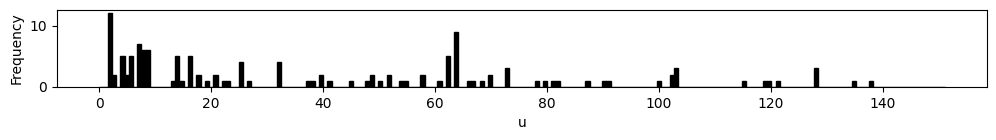

[]
[[...]]
['0.8352480000000001 <= A3 <= 6.23566', '0.36729 <= A5 <= 33.06316']
['0.8352480000000001 <= A3 <= 6.23566', '0.10197 <= A1 <= 34.21388']
['0.36729 <= A5 <= 33.06316', '0.10197 <= A1 <= 34.21388']
['-0.3666 <= A1 <= -0.34786']
['-0.04764 <= A4 <= 0.52025', '0.10197 <= A1 <= 34.21388']
['-0.06268 <= A5 <= 0.36729', '0.10197 <= A1 <= 34.21388']
['0.8352480000000001 <= A3 <= 6.23566', '-0.04764 <= A4 <= 0.52025']
['0.8352480000000001 <= A3 <= 6.23566', '-0.06268 <= A5 <= 0.36729']
['-0.06268 <= A5 <= 0.36729']
['-0.04764 <= A4 <= 0.52025']
['0.10197 <= A1 <= 34.21388']
['-0.6794 <= A6 <= -0.51807']
['-0.6794 <= A6 <= -0.51807', '-0.34309 <= A5 <= -0.06268']
['-0.70097 <= A4 <= -0.38436']
['-0.6794 <= A6 <= -0.51807', '-0.4149819999999999 <= A3 <= 0.08979']
['-0.928688 <= A3 <= -0.4149819999999999']
['-0.43846 <= A2 <= -0.43846', '-0.04764 <= A4 <= 0.52025']
['-0.70097 <= A4 <= -0.38436', '-0.928688 <= A3 <= -0.4149819999999999']
['-0.04764 <= A4 <= 0.52025', '-0.414981999999999

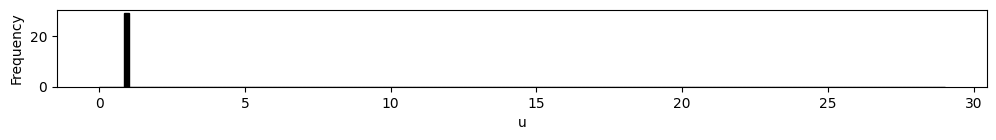

[[...]]
[[...], [...]]
['0.2909699 <= Companiesbytypebusinessservices <= 0.442088091', '3.8 <= Migrationbackgroundremainingnonwestern <= 5.1', '77.6 <= Dutchbackground <= 84.0']
['0.4 <= MigrationbackgroundformerDutchAntillesAruba <= 0.7', '0.0 <= Furanimalsnr <= 0.0', '0.087837838 <= Companiesbytypetransportinformationandcomunication <= 0.155615697']
['1.0 <= MigrationbackgroundSuriname <= 11.5', '0.195479536 <= Studentshbo <= 0.206682353', '0.0 <= Otherpoultrynr <= 0.0']
['0.2909699 <= Companiesbytypebusinessservices <= 0.442088091', '0.7 <= MigrationbackgroundMaroccan <= 1.9', '0.0 <= Ducksforslaughternr <= 0.0']
['1.0 <= MigrationbackgroundSuriname <= 11.5', '0.0 <= Cultivatedlandare <= 79430.0', '0.507380936 <= Women <= 0.529343972']
['0.0 <= Furanimalsnr <= 0.0', '77.6 <= Dutchbackground <= 84.0', '0.087837838 <= Companiesbytypetransportinformationandcomunication <= 0.155615697']
['1.0 <= MigrationbackgroundSuriname <= 11.5', '0.087837838 <= Companiesbytypetransportinformationand

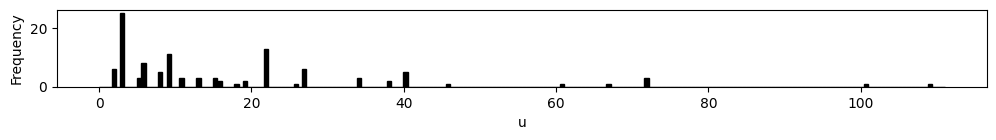

[[...], [...]]
[[...], [...], [...]]
['1.0 <= failures <= 3.0', "school == 'GP'", "paid == 'no'"]
['2.0 <= freetime <= 3.0', "romantic == 'yes'", '0.0 <= absences <= 0.0']
["activities == 'yes'", '0.0 <= absences <= 0.0', '0.0 <= Medu <= 2.0']
['1.0 <= failures <= 3.0', "nursery == 'yes'"]
['0.0 <= Fedu <= 1.0', '0.0 <= absences <= 0.0', '0.0 <= Medu <= 2.0']
["famsize == 'GT3'", '1.0 <= failures <= 3.0', "internet == 'yes'"]
["address == 'U'", '1.0 <= failures <= 3.0', "schoolsup == 'no'"]
["romantic == 'yes'", '0.0 <= absences <= 0.0', '0.0 <= Medu <= 2.0']
["famsup == 'yes'", '0.0 <= absences <= 0.0', "paid == 'no'"]
["guardian == 'mother'", '0.0 <= absences <= 0.0', '0.0 <= Medu <= 2.0']
["guardian == 'mother'", '0.0 <= absences <= 0.0', '1.0 <= studytime <= 1.0']
["Fjob == 'other'", "activities == 'yes'", '0.0 <= absences <= 0.0']
["famsup == 'yes'", '0.0 <= absences <= 0.0', '0.0 <= Medu <= 2.0']
["romantic == 'yes'", "famsup == 'yes'", '0.0 <= absences <= 0.0']
['1.0 <= failures

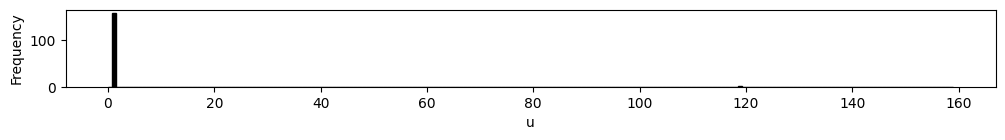

[[...], [...], [...]]
[[...], [...], [...], [...]]
['0.0 <= failures <= 3.0', "famsup == 'no'", "nursery == 'yes'"]
['0.0 <= failures <= 3.0', "paid == 'no'", "nursery == 'yes'"]
['3.0 <= Medu <= 4.0', '1.0 <= Walc <= 1.0', '3.0 <= famrel <= 4.0']
['0.0 <= failures <= 3.0', "paid == 'no'", '4.0 <= health <= 5.0']
["activities == 'yes'", '0.0 <= failures <= 3.0']
['0.0 <= failures <= 3.0', '3.0 <= famrel <= 4.0', "Pstatus == 'T'"]
["sex == 'F'", '3.0 <= famrel <= 4.0', '3.0 <= Medu <= 4.0']
["address == 'U'", '0.0 <= failures <= 3.0', "internet == 'yes'"]
['0.0 <= absences <= 0.0', "sex == 'F'", '3.0 <= Medu <= 4.0']
['0.0 <= failures <= 3.0', "internet == 'yes'", "sex == 'F'"]
['3.0 <= Medu <= 4.0', '1.0 <= Dalc <= 1.0', '3.0 <= famrel <= 4.0']
['1.0 <= Walc <= 1.0', '3.0 <= Medu <= 4.0', '1.0 <= traveltime <= 1.0']
['0.0 <= failures <= 0.0', '1.0 <= goout <= 2.0', "reason == 'reputation'"]
['2.0 <= freetime <= 3.0', "sex == 'F'", '3.0 <= Medu <= 4.0']
["higher == 'yes'", "Fjob == 'tea

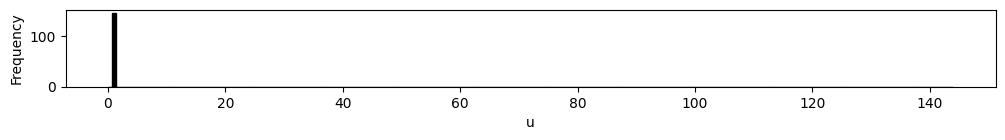

[[...], [...], [...], [...]]
[[...], [...], [...], [...], [...]]
['-4.35408 <= A4 <= -0.81551', '0.24224 <= A8 <= 0.79837']
['-4.35408 <= A4 <= -0.81551', '-0.2802 <= A9 <= -0.06954']
['0.21181 <= A1 <= 0.86744', '-4.35408 <= A4 <= -0.81551']
['-4.35408 <= A4 <= -0.81551']
['0.24224 <= A8 <= 0.79837']
['-0.2802 <= A9 <= -0.06954', '0.24224 <= A8 <= 0.79837']
['-4.35408 <= A4 <= -0.81551', '-3.38844 <= A2 <= -0.79408']
['-4.35408 <= A4 <= -0.81551', '-0.29502 <= A6 <= 0.43621']
['-0.2802 <= A9 <= -0.06954', '-0.29502 <= A6 <= 0.43621']
['0.21181 <= A1 <= 0.86744', '-0.2802 <= A9 <= -0.06954']
['-0.29502 <= A6 <= 0.43621']
['-0.2802 <= A9 <= -0.06954']
['-0.90165 <= A3 <= -0.28965']
['0.21181 <= A1 <= 0.86744']
['-0.2802 <= A9 <= -0.06954', '-0.90165 <= A3 <= -0.28965']
['-0.3645 <= A5 <= 0.26595', '-0.2802 <= A9 <= -0.06954']
['-0.29502 <= A6 <= 0.43621', '-3.38844 <= A2 <= -0.79408']
['-0.2802 <= A9 <= -0.06954', '-3.38844 <= A2 <= -0.79408']
['-0.3645 <= A5 <= 0.26595']
['-3.38844 <= 

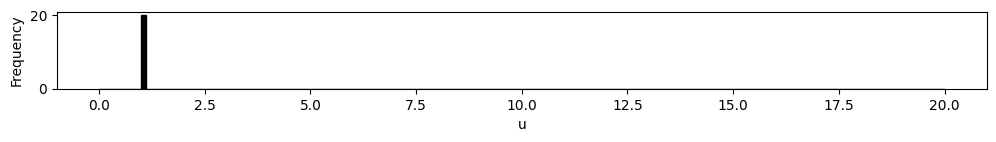

[[...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...]]
["A4 == '0'"]
['-0.97795 <= A1 <= -0.36049', '-0.52479 <= A7 <= -0.04654', '-0.9292 <= A6 <= -0.51144']
['-2.18251 <= A6 <= -0.9292']
['-0.81173 <= A7 <= -0.52479', '-2.29829 <= A2 <= -0.81116']
["A4 == '0'", '-0.52479 <= A7 <= -0.04654', '-2.29829 <= A2 <= -0.81116']
["A4 == '0'", '-2.18251 <= A6 <= -0.9292', '-0.73678 <= A5 <= -0.32759']
['-2.18251 <= A6 <= -0.9292', "A3 == '0'", '-0.81116 <= A2 <= -0.40558']
["A4 == '0'", '-2.18251 <= A6 <= -0.9292', '-2.57306 <= A1 <= -0.97795']
['-0.97795 <= A1 <= -0.36049', '-2.29829 <= A2 <= -0.81116']
["A4 == '0'", '-0.51144 <= A6 <= 0.13843']
['-0.97795 <= A1 <= -0.36049', '-2.18251 <= A6 <= -0.9292']
['-0.51144 <= A6 <= 0.13843', '-0.04654 <= A7 <= 1.14906']
["A3 == '0'", '-0.9292 <= A6 <= -0.51144', '-0.73678 <= A5 <= -0.32759']
["A3 == '0'", '-0.73678 <= A5 <= -0.32759', '-2.29829 <= A2 <= -0.81116']
["A3 == '0'", '-0.52479 <= A7 <= -0.04654', '-0.9292 <= A6 <= -

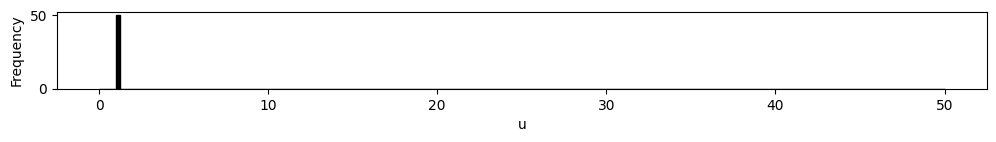

[[...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...]]
['0.09842799999999996 <= A13 <= 1.0']
['0.43473599999999996 <= A1 <= 1.0', '0.11392 <= A7 <= 1.0']
['-1.0 <= A4 <= -0.36083', '0.09842799999999996 <= A13 <= 1.0']
['-0.025600000000000147 <= A10 <= 1.0']
['0.09842799999999996 <= A13 <= 1.0', '0.29655 <= A6 <= 1.0']
['-1.0 <= A4 <= -0.36083', '0.45788 <= A12 <= 1.0']
['-0.08571600000000003 <= A12 <= 0.19560600000000003', '0.09842799999999996 <= A13 <= 1.0']
['0.09842799999999996 <= A13 <= 1.0', '-0.69565 <= A2 <= -0.6087']
['0.43473599999999996 <= A1 <= 1.0', '-0.316726 <= A10 <= -0.025600000000000147']
['0.09842799999999996 <= A13 <= 1.0', '-0.005674000000000036 <= A9 <= 1.0']
['-0.08943 <= A11 <= 0.09918599999999991', '0.09842799999999996 <= A13 <= 1.0']
['-0.10548999999999994 <= A7 <= 0.11392', '0.09842799999999996 <= A13 <= 1.0']
['-0.69565 <= A2 <= -0.6087', '-0.316726 <= A10 <= -0.025600000000000147']
['-1.0 <= A4 <= -0.36083', '-0.69565 <=

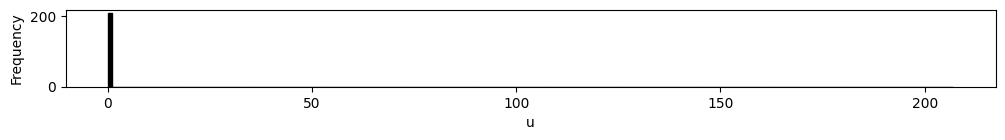

[[...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...]]
["sex == '0'", '1.0 <= age <= 2.0', "changed_city == '1'"]
["sex == '0'", "lived_in_region == '3:Kanto+Shizuoka'", "changed_city == '1'"]
["changed_city == '1'", "sex == '0'", "lives_in_region == '3:Kanto+Shizuoka'"]
["sex == '0'", '3.0 <= age <= 5.0']
["sex == '0'", '1.0 <= age <= 2.0', "lived_in_region == '3:Kanto+Shizuoka'"]
["sex == '0'"]
["sex == '0'", '222.0 <= answer_duration <= 257.0', "lived_in == '0'"]
["sex == '0'", "lives_in == '0'", "lives_in_region == '3:Kanto+Shizuoka'"]
["lived_in_region == '0:Hokkaido'", "lived_in == '0'", "lived_in_prefecture == '0:Hokkaido'"]
["sex == '0'", "lived_in == '1'", "changed_city == '1'"]
["sex == '0'", '297.0 <= answer_duration <= 363.0']
["sex == '0'", "lives_in == '0'", '2.0 <= age <= 3.0']
["lives_in_prefecture == '13:Tokyo'", "sex == '0'", "lives_in_region == '3:Kanto+Shizuoka'"]
["lived_in_prefecture == '13:Tokyo'", "sex == '0'",

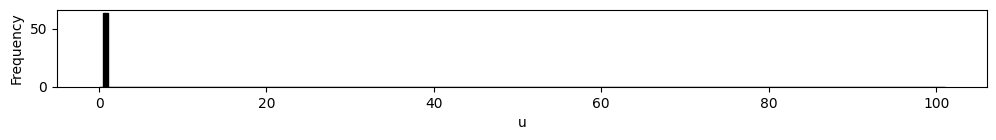

[[...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...]]
["industry == 'Insurance—Diversified'"]
['35600.0 <= fullTimeEmployees <= 413000.0', "sector == 'Consumer Defensive'"]
['8.224 <= enterpriseToEbitda <= 11.0404', "country == 'Netherlands'", "sector == 'Consumer Defensive'"]
["currency == 'EUR'", "country == 'Netherlands'", "sector == 'Consumer Defensive'"]
['35600.0 <= fullTimeEmployees <= 413000.0', '11.0404 <= enterpriseToEbitda <= 16.212000000000007', '18115285201.32213 <= marketCap <= 269244729859.7683']
['35600.0 <= fullTimeEmployees <= 413000.0', '18115285201.32213 <= marketCap <= 269244729859.7683', "currency == 'EUR'"]
['35600.0 <= fullTimeEmployees <= 413000.0', '8782561308.614655 <= marketCap <= 18115285201.32213']
['378074027.5594241 <= marketCap <= 1599407090.96448', '76.925 <= debtToEquity <= 128.823']
['11.0404 <= enterpriseToEbitda <= 16.212000000000007', "sector == 'Industrials'", "country == 'Netherl

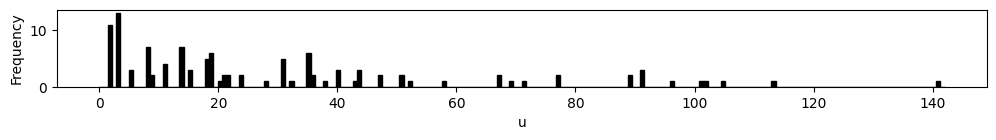

[[...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
['85412.0 <= fullTimeEmployees <= 420000.0', "country == 'France'", '34142.80000000007 <= averageVolume10days <= 458564110.0']
['85412.0 <= fullTimeEmployees <= 420000.0', "currency == 'EUR'"]
['13282031246.475264 <= marketCap <= 382539839126.8966', '85412.0 <= fullTimeEmployees <= 420000.0']
['6.7614 <= enterpriseToEbitda <= 9.8202', '85412.0 <= fullTimeEmployees <= 420000.0']
['13282031246.475264 <= marketCap <= 382539839126.8966', '56.8772 <= debtToEquity <= 85.604', "country == 'France'"]
['13282031246.475264 <= marketCap <= 382539839126.8966', "country == 'France'", '9.8202 <= enterpriseToEbitda <= 17.75260000000003']
["currency == 'USD'", '85412.0 <= fullTimeEmployees <= 420000.0']
['13282031246.475264 <= marketCap <= 382539839126.8966', "country == 'France'", "exchangeTimezoneName == 'Europe/Berlin'"]
['11171.0 <= fullTimeEmployees <= 85412.0', "

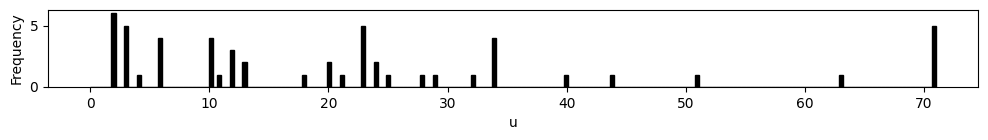

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
["country == 'Germany'", "currency == 'EUR'"]
['21400.0 <= fullTimeEmployees <= 641900.0', '7894834326.904834 <= marketCap <= 143122822594.56', '9276.400000000005 <= averageVolume10days <= 7562901.0']
['21400.0 <= fullTimeEmployees <= 641900.0', '7894834326.904834 <= marketCap <= 143122822594.56', "currency == 'EUR'"]
['21400.0 <= fullTimeEmployees <= 641900.0', '7894834326.904834 <= marketCap <= 143122822594.56', '7.1142 <= enterpriseToEbitda <= 10.8908']
["country == 'Germany'", '21400.0 <= fullTimeEmployees <= 641900.0', "exchangeTimezoneName == 'America/New_York'"]
["country == 'Germany'", '7894834326.904834 <= marketCap <= 143122822594.56', '41.51180000000001 <= debtToEquity <= 74.708']
['21400.0 <= fullTimeEmployees <= 641900.0', "currency == 'EUR'", "exchange == 'FRA'"]
["country == 'Germany'", '5796.0 <= fullTimeEmployees <= 21400.

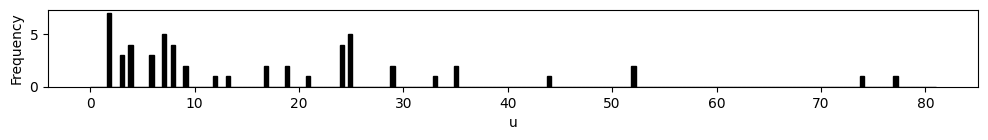

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
['5252.000000000001 <= fullTimeEmployees <= 616171.0', '755608.0 <= averageVolume10days <= 153812144.0']
["sector == 'Industrials'"]
['81410869.83680002 <= marketCap <= 280063786.5984', '3.4332000000000003 <= enterpriseToEbitda <= 8.058']
["country == 'India'", '3.4332000000000003 <= enterpriseToEbitda <= 8.058']
["country == 'India'", '5252.000000000001 <= fullTimeEmployees <= 616171.0']
["country == 'India'", '8.058 <= enterpriseToEbitda <= 13.8196']
["country == 'India'", '52.715999999999994 <= debtToEquity <= 121.79520000000004']
["country == 'India'", "sector == 'Consumer Cyclical'", '14205.600000000004 <= averageVolume10days <= 60898.600000000006']
['18129998.745600004 <= marketCap <= 81410869.83680002', '60898.600000000006 <= averageVolume10days <= 196741.39999999994', "currency == 'INR'"]
['81410869.83680002 <= market

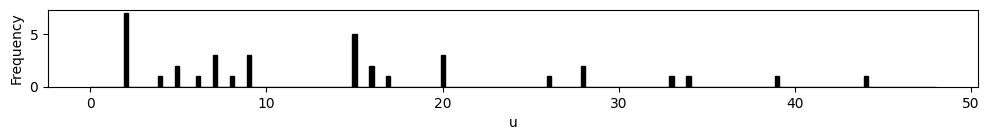

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
['9096.0 <= fullTimeEmployees <= 197773.0']
['1819466844.7191048 <= marketCap <= 158910715527.168', "country == 'Australia'", '69.877 <= debtToEquity <= 12052.27']
['69.877 <= debtToEquity <= 12052.27', '3.266399999999999 <= enterpriseToEbitda <= 10.55']
['1819466844.7191048 <= marketCap <= 158910715527.168', "country == 'Australia'", '3.266399999999999 <= enterpriseToEbitda <= 10.55']
['69.877 <= debtToEquity <= 12052.27', '10.55 <= enterpriseToEbitda <= 25860.809']
['3283.0 <= fullTimeEmployees <= 9096.0', "country == 'Australia'"]
['1819466844.7191048 <= marketCap <= 158910715527.168', "country == 'Australia'", "currency == 'EUR'"]
["country == 'Australia'", "sector == 'Financial Services'"]
['1819466844.7191048 <= marketCap <= 158910715527.168', '10.55 <= enterpriseToEbitda <= 25860.809']
['1819466844.719104

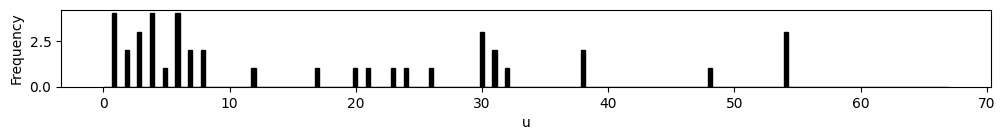

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
['2593.0 <= fullTimeEmployees <= 70707.0', '1779349310.668801 <= marketCap <= 317910023135.55963', "country == 'South Korea'"]
["country == 'South Korea'", "sector == 'Consumer Defensive'"]
['1.8182 <= enterpriseToEbitda <= 4.466400000000001', '1779349310.668801 <= marketCap <= 317910023135.55963', "country == 'South Korea'"]
["exchange == 'KSC'", '1.8182 <= enterpriseToEbitda <= 4.466400000000001', '0.004 <= debtToEquity <= 13.178']
['1779349310.668801 <= marketCap <= 317910023135.55963']
['0.0 <= averageVolume10days <= 7165.000000000003', '1779349310.668801 <= marketCap <= 317910023135.55963', "country == 'South Korea'"]
['1.8182 <= enterpriseToEbitda <= 4.466400000000001', "country == 'South Korea'"]
["sector == 'Financial Services'", "country == 'South Korea'"]
['1779349310.668801 <= marketCap 

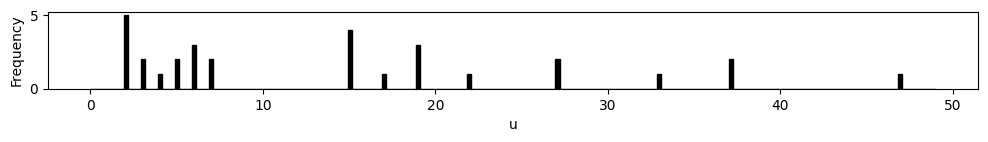

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
["country == 'Indonesia'", '7168.0 <= fullTimeEmployees <= 126079.0', "sector == 'Consumer Defensive'"]
['7168.0 <= fullTimeEmployees <= 126079.0', '363361274.06233615 <= marketCap <= 1573532814.0451844']
["sector == 'Real Estate'"]
['7168.0 <= fullTimeEmployees <= 126079.0', "exchange == 'JKT'"]
["country == 'Indonesia'", '0.0 <= averageVolume10days <= 12.0', '7168.0 <= fullTimeEmployees <= 126079.0']
["sector == 'Consumer Defensive'"]
["country == 'Indonesia'", "industry == 'Farm Products'", "sector == 'Consumer Defensive'"]
["country == 'Indonesia'", '1573532814.0451844 <= marketCap <= 72041906176.0', '7168.0 <= fullTimeEmployees <= 126079.0']
["exchangeTimezoneName == 'Asia/Jakarta'", '2.66 <= enterpriseToEbitda <= 7.212']
["exchangeTimezoneName == 'Asia/Jakarta'", '226.6000000000

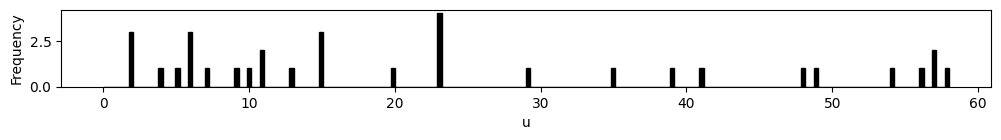

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
["sector == 'Financial'", "industry == 'REIT - Diversified'", "country == 'Brazil'"]
["currency == 'EUR'", "country == 'Brazil'", "exchange == 'FRA'"]
['1.175 <= enterpriseToEbitda <= 3.955', "country == 'Brazil'", '4216084237.123584 <= marketCap <= 84711094285.76256']
['30000.0 <= fullTimeEmployees <= 250000.0', '4216084237.123584 <= marketCap <= 84711094285.76256']
["sector == 'Real Estate'", "exchange == 'SAO'", "country == 'Brazil'"]
["country == 'Brazil'", '5025.0 <= fullTimeEmployees <= 11225.0']
['11225.0 <= fullTimeEmployees <= 30000.0', "country == 'Brazil'"]
["sector == 'Utilities'", '3.955 <= enterpriseToEbitda <= 6.279', "country == 'Brazil'"]
["country == 'Brazil'", '4216084237.123584 <= marketCap <= 84711094285.76256']
["sector == 'Utilities'", '1037434238.

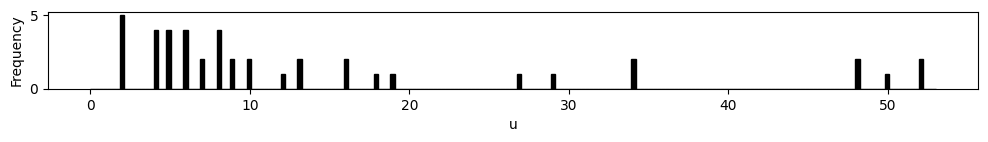

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
["country == 'United States'", '21760.0 <= fullTimeEmployees <= 2300000.0']
['36.09500000000002 <= debtToEquity <= 70.049', "currency == 'EUR'"]
["exchangeTimezoneName == 'Europe/Berlin'", '21760.0 <= fullTimeEmployees <= 2300000.0']
['7222688665.6 <= marketCap <= 1.0602763499077632e+16', '21760.0 <= fullTimeEmployees <= 2300000.0']
['7222688665.6 <= marketCap <= 1.0602763499077632e+16', "country == 'United States'"]
["country == 'Japan'"]
["country == 'United States'", '131.653 <= debtToEquity <= 100061.75']
["currency == 'USD'", "sector == 'Industrials'"]
['131.653 <= debtToEquity <= 100061.75']
["currency == 'EUR'", '131.653 <= debtToEquity <= 100061.75']
['1227861818.425343 <= marketCap <= 7222688665.6', '0.0 <= averageVolume10days <= 0.0']
["sector == 

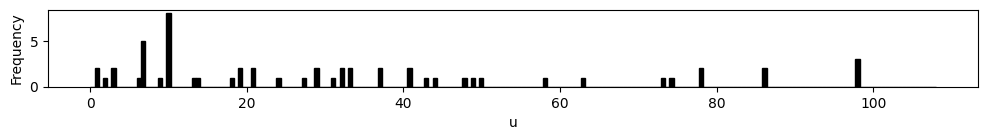

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]


In [4]:
datasets = get_data('all')
# del datasets['voting']

keys = list(datasets.keys())
print(keys)
names = []
for data_set_key in datasets.keys():

    data, target, matrix = datasets[data_set_key]
    data_copy = data.copy()
    
    # data = convert_columns_num_to_cat(data,nr_chunks=5)
    description_column = 'results_non_redundant' #'results_non_redundant' 'results_descriptions'
    descriptions = df.loc[df['dataset_name']==data_set_key][description_column].iloc[0]
    
    for desc in descriptions:
        print(desc)

    print(" ")
    print(data_set_key)
    name = parameter_u_analysis(data, matrix, descriptions, data_set_key)
    names.append(name)
    print(names)


In [5]:
for i in names:
    
    print(r"\begin{figure}[htbp]")
    print(r"    \centering")
    print(r"    \includesvg[width=0.5\textwidth]figures/{test}".format(test=i[0]))
    print(r"    \caption{Running time vs. redundancy on logarithmic scale for different benchmark datasets (different colors) for the different algorithms (different markers).}")
    print(r"    \label{fig:time_redundancy}")
    print(r"\end{figure}")
    

\begin{figure}[htbp]
    \centering
    \includesvg[width=0.5\textwidth]figures/[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
    \caption{Running time vs. redundancy on logarithmic scale for different benchmark datasets (different colors) for the different algorithms (different markers).}
    \label{fig:time_redundancy}
\end{figure}
\begin{figure}[htbp]
    \centering
    \includesvg[width=0.5\textwidth]figures/[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]
    \caption{Running time vs. redundancy on logarithmic scale for different benchmark datasets (different colors) for the different algorithms (different markers).}
    \label{fig:time_redundancy}
\end{figure}
\begin{figure}[htbp]
    \centering
    \includesvg[width=0.5\textwidth]figures/[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [...], [

## Archive